# Imports, Seeds

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

import os
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns

import time

from weatherbench2.visualization import set_wb2_style
from weatherbench2.metrics import _spatial_average

import multiprocessing
import concurrent.futures
from tqdm import tqdm

import random

In [2]:
# Set seeds
os.environ['PYTHONHASHSEED']=str(1)
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(gpu)
        gpu_details = tf.config.experimental.get_device_details(gpu)
        print(f"Name: {gpu_details['device_name']}")

        # Extracting the GPU device index and formatting it correctly
        try:
            gpu_index = gpu.name.split(':')[2]  # This splits the name and takes the third part, e.g., "0" from "/physical_device:GPU:0"
            memory_info = tf.config.experimental.get_memory_info(f"GPU:{gpu_index}")
            print(f"Memory Total: {memory_info['total'] / 1e9:.2f} GB")
            print(f"Memory Available: {memory_info['current'] / 1e9:.2f} GB")
        except Exception as e:
            print(f"Could not retrieve memory info for {gpu.name}: {e}")
        print('-' * 40)
else:
    print("No GPU devices found.")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Name: NVIDIA RTX A5000
Could not retrieve memory info for /physical_device:GPU:0: 'total'
----------------------------------------
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Name: NVIDIA RTX A5000
Could not retrieve memory info for /physical_device:GPU:1: 'total'
----------------------------------------


In [7]:
tf.test.is_gpu_available(True, (8,0))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [9]:
set_wb2_style()

In [10]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 34})

# Functions

In [11]:
def min_max_scale(data):
    """
    Scales the input data using Min-Max scaling to a range of [0, 1].

    Args:
    data (numpy.ndarray): Data to be scaled.

    Returns:
    scaled_data (numpy.ndarray): Scaled data with values between 0 and 1.
    min_val (numpy.ndarray): Minimum values for each feature, used for scaling.
    max_val (numpy.ndarray): Maximum values for each feature, used for scaling.
    """
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data, min_val, max_val

In [12]:
def np_spatial_avg(values, forecast_global):
    """
    Calculates the spatial average of a numpy.ndarray based on the global forecast coordinates.

    Parameters:
        - values (numpy.ndarray): Array of values to be averaged.
        - forecast_global (xarray.Dataset): Global forecast dataset containing longitude and latitude coordinates.

    Returns:
        float: Spatial average of the input values.
    """
    # Create a DataArray using the provided values and coordinates from forecast_global
    da = xr.DataArray(
            values,
            dims=['latitude', 'longitude'],
            coords={'longitude': forecast_global.longitude, 'latitude': forecast_global.latitude}
        )
    
    # Calculate the spatial average using the weatherbench2 function _spatial_average
    result = _spatial_average(da).values.item()
    
    return result

In [13]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [14]:
def build_model(n_features, n_outputs, hidden_units=[], emb_size=None, max_id=None, compile=True, optimizer='adam', lr=0.01, loss=crps_normal_cost_function, activation='relu', reg=None):
    """

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer
        reg: Regularizer to be applied

    Returns:
        model: Keras model
    """
    
    # Ensure hidden_nodes is a list
    if type(hidden_units) is not list:
        hidden_units = [hidden_units]
    
    # Input layer
    features_in = Input(shape=(n_features,))
    
    if emb_size is None:
        x = features_in
    else:
        id_in = Input(shape=(1,))
        emb = Embedding(max_id + 1, emb_size)(id_in)
        emb = Flatten()(emb)
        x = Concatenate()([features_in, emb])
    
    # Hidden layers
    for units in hidden_units:
        x = Dense(units, activation=activation, kernel_regularizer=reg)(x)

    # Output layer
    outputs = Dense(n_outputs, activation='linear', kernel_regularizer=reg)(x)
        
    # Create model
    model_inputs = [features_in, id_in] if emb_size is not None else features_in
    model = Model(inputs=model_inputs, outputs=outputs)

    # Compile model
    if compile:
        model.compile(optimizer=Adam(learning_rate=lr), loss=loss)
        
    return model

In [15]:
def build_model_pos_out(n_features, n_outputs, hidden_units=[], emb_size=None, max_id=None, compile=True, optimizer='adam', lr=0.01, loss=crps_normal_cost_function, activation='relu', reg=None, dropout_rate=None):
    """

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer
        reg: Regularizer to be applied

    Returns:
        model: Keras model
    """
    
    # Ensure hidden_nodes is a list
    if type(hidden_units) is not list:
        hidden_units = [hidden_units]
    
    # Input layer
    features_in = Input(shape=(n_features,))
    
    if emb_size is None:
        x = features_in
    else:
        id_in = Input(shape=(1,))
        emb = Embedding(max_id + 1, emb_size)(id_in)
        emb = Flatten()(emb)
        x = Concatenate()([features_in, emb])
    
    # Hidden layers
    for units in hidden_units:
        x = Dense(units, activation=activation, kernel_regularizer=reg)(x)
        if dropout_rate is not None:
            x = Dropout(dropout_rate)(x)
        
    # Separate output layers for mean and standard deviation
    output_mean = Dense(1, activation='linear')(x)  # linear activation
    output_sigma = Dense(1, activation='softplus')(x)  # softplus activation

    # Concatenate the outputs
    outputs = Concatenate()([output_mean, output_sigma])
        
    # Create model
    model_inputs = [features_in, id_in] if emb_size is not None else features_in
    model = Model(inputs=model_inputs, outputs=outputs)

    # Compile model
    if compile:
        model.compile(optimizer=Adam(learning_rate=lr), loss=loss)
        
    return model

In [19]:
def encode_coordinates_trigonometric(df): 
    df['longitude_sin'] = np.sin(np.radians(df['longitude']))
    df['longitude_cos'] = np.cos(np.radians(df['longitude']))
    df['latitude_sin'] = np.sin(np.radians(df['latitude'] + 90))
    df['latitude_cos'] = np.cos(np.radians(df['latitude'] + 90))
    return df.drop(columns=['longitude', 'latitude'])

# Hyperparameter Optimization

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, restore_best_weights=True)

In [ ]:
%%time
# Load PANGU data
forecast = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850)
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
forecast = forecast.compute()

# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

In [17]:
n_features = 5  
n_outputs = 2  
hidden_units_list = [64, 512]
emb_size_list = [2,5,15]
max_id = forecast['location_id'].max().values
batch_size = 8192

In [32]:
for hidden_units in hidden_units_list:
    for emb_size in emb_size_list:
        for regularization in [False, True]:
            
            print(f'Hidden Units: {hidden_units}, Embedding Size: {emb_size}, Regularization: {regularization}')
            
            if regularization:
                reg=l2(0.01)
            else:
                reg=None
        
            results_df = pd.DataFrame()

            #Achtung nur jede 4. lead_time
            for lead_time in tqdm(forecast.isel(prediction_timedelta=slice(3, None, 4)).prediction_timedelta.values): 
                
                start_time = time.time()
                
                forecast_subset = forecast.sel(prediction_timedelta=lead_time)

                # Split forecast data into training and test sets
                forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                                         forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
                forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
                forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

                # Load ERA5 data
                obs_train = obs.sel(time=forecast_train.time + lead_time)
                obs_val = obs.sel(time=forecast_val.time + lead_time)
                obs_test = obs.sel(time=forecast_test.time + lead_time)

                # Extract dataframes
                forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
                forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
                forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
                obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
                obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
                obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])

                for col in forecast_train_df.columns[:-1]:
                    # Apply the scaler to the training data
                    forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
                    # Apply the same scaler to the validation and test data
                    forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
                    forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

                # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
                tf.compat.v1.reset_default_graph()
                tf.keras.backend.clear_session()

                # Model definition
                model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=reg)

                # Fit
                model.fit(
                    [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
                    obs_train_df.temperature.to_numpy(), 
                    validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df.temperature.to_numpy()),
                    epochs=100, 
                    verbose=0, 
                    batch_size=batch_size,
                    callbacks=[early_stopping]
                    )

                # Predict
                train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
                val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
                test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)

                # Evaluate
                train_crps = crps_normal_cost_function(obs_train_df.temperature.to_numpy(), train_predictions, tensor=False)
                val_crps = crps_normal_cost_function(obs_val_df.temperature.to_numpy(), val_predictions, tensor=False)
                test_crps = crps_normal_cost_function(obs_test_df.temperature.to_numpy(), test_predictions, tensor=False)

                # Calculate Spatial metrics
                spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
                spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
                spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

                spatial_test_mae = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - test_predictions[:,0]).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
                spatial_train_mae = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - train_predictions[:,0]).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
                spatial_val_mae = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - val_predictions[:,0]).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

                spatial_test_mse = np_spatial_avg(((obs_test_df.temperature.to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
                spatial_train_mse = np_spatial_avg(((obs_train_df.temperature.to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
                spatial_val_mse = np_spatial_avg(((obs_val_df.temperature.to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

                spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
                spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
                spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

                # Calculate MAE and MSE for deterministic forecast
                spatial_test_mae_det = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - (forecast_test_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
                spatial_train_mae_det = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - (forecast_train_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
                spatial_val_mae_det = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - (forecast_val_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

                spatial_test_mse_det = np_spatial_avg(((obs_test_df.temperature.to_numpy() - (forecast_test_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
                spatial_train_mse_det = np_spatial_avg(((obs_train_df.temperature.to_numpy() - (forecast_train_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
                spatial_val_mse_det = np_spatial_avg(((obs_val_df.temperature.to_numpy() - (forecast_val_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))  

                train_eval_time = time.time() - start_time
                
                temp_results = {
                    'lead_time': lead_time,
                    'crps_test': spatial_mean_test_crps,
                    'crps_train': spatial_mean_train_crps,
                    'crps_val': spatial_mean_val_crps,
                    'mae_test': spatial_test_mae,
                    'mae_train': spatial_train_mae,
                    'mae_tval': spatial_val_mae,
                    'mse_test': spatial_test_mse,
                    'mse_train': spatial_train_mse,
                    'mse_val': spatial_val_mse,
                    'var_test': spatial_test_var,
                    'var_train': spatial_train_var,
                    'var_val': spatial_val_var,
                    'mae_test_det': spatial_test_mae_det,
                    'mae_train_det': spatial_train_mae_det,
                    'mae_val_det': spatial_val_mae_det,
                    'mse_test_det': spatial_test_mse_det,
                    'mse_train_det': spatial_train_mse_det,
                    'mse_val_det': spatial_val_mse_det,
                    'train_eval_time': train_eval_time
                }
                temp_df = pd.DataFrame([temp_results])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
            results_df.to_pickle(f'DRN/pangu_vs_era5_aux_input_hidden{hidden_units}_emb{emb_size}_reg{regularization}_experiment.pkl')

Hidden Units: 64, Embedding Size: 2, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:25<00:00, 56.58s/it]


Hidden Units: 64, Embedding Size: 2, Regularization: True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [43:50<00:00, 263.01s/it]


Hidden Units: 64, Embedding Size: 5, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:40<00:00, 64.01s/it]


Hidden Units: 64, Embedding Size: 5, Regularization: True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [34:08<00:00, 204.90s/it]


Hidden Units: 64, Embedding Size: 15, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:50<00:00, 59.01s/it]


Hidden Units: 64, Embedding Size: 15, Regularization: True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [41:07<00:00, 246.70s/it]


Hidden Units: 512, Embedding Size: 2, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:00<00:00, 48.02s/it]


Hidden Units: 512, Embedding Size: 2, Regularization: True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [34:41<00:00, 208.14s/it]


Hidden Units: 512, Embedding Size: 5, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:26<00:00, 50.65s/it]


Hidden Units: 512, Embedding Size: 5, Regularization: True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [31:58<00:00, 191.81s/it]


Hidden Units: 512, Embedding Size: 15, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:38<00:00, 45.84s/it]


Hidden Units: 512, Embedding Size: 15, Regularization: True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [33:20<00:00, 200.06s/it]


In [21]:
# linear
for emb_size in emb_size_list:
    for regularization in [True, False]: # not necessary! Regularization only on Hidden Layers.

        print(f'Embedding Size: {emb_size}, Regularization: {regularization}')

        if regularization:
            reg=l2(0.01)
        else:
            reg=None

        results_df = pd.DataFrame()

        #Achtung nur jede 4. lead_time
        for lead_time in tqdm(forecast.isel(prediction_timedelta=slice(3, None, 4)).prediction_timedelta.values): 

            start_time = time.time()

            forecast_subset = forecast.sel(prediction_timedelta=lead_time)

            # Split forecast data into training and test sets
            forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                                     forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
            forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
            forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

            # Load ERA5 data
            obs_train = obs.sel(time=forecast_train.time + lead_time)
            obs_val = obs.sel(time=forecast_val.time + lead_time)
            obs_test = obs.sel(time=forecast_test.time + lead_time)

            # Extract dataframes
            forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
            forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
            forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
            obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
            obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
            obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])

            for col in forecast_train_df.columns[:-1]:
                # Apply the scaler to the training data
                forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
                # Apply the same scaler to the validation and test data
                forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
                forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

            # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
            tf.compat.v1.reset_default_graph()
            tf.keras.backend.clear_session()

            # Model definition
            model = build_model_pos_out(n_features, n_outputs, emb_size=emb_size, max_id=max_id, lr=0.01, reg=reg)

            # Fit
            model.fit(
                [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
                obs_train_df.temperature.to_numpy(), 
                validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df.temperature.to_numpy()),
                epochs=100, 
                verbose=0, 
                batch_size=batch_size,
                callbacks=[early_stopping]
                )

            # Predict
            train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
            val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
            test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)

            # Evaluate
            train_crps = crps_normal_cost_function(obs_train_df.temperature.to_numpy(), train_predictions, tensor=False)
            val_crps = crps_normal_cost_function(obs_val_df.temperature.to_numpy(), val_predictions, tensor=False)
            test_crps = crps_normal_cost_function(obs_test_df.temperature.to_numpy(), test_predictions, tensor=False)

            # Calculate Spatial metrics
            spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
            spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
            spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

            spatial_test_mae = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - test_predictions[:,0]).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
            spatial_train_mae = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - train_predictions[:,0]).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
            spatial_val_mae = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - val_predictions[:,0]).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

            spatial_test_mse = np_spatial_avg(((obs_test_df.temperature.to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
            spatial_train_mse = np_spatial_avg(((obs_train_df.temperature.to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
            spatial_val_mse = np_spatial_avg(((obs_val_df.temperature.to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

            spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
            spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
            spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

            # Calculate MAE and MSE for deterministic forecast
            spatial_test_mae_det = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - (forecast_test_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
            spatial_train_mae_det = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - (forecast_train_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
            spatial_val_mae_det = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - (forecast_val_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

            spatial_test_mse_det = np_spatial_avg(((obs_test_df.temperature.to_numpy() - (forecast_test_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
            spatial_train_mse_det = np_spatial_avg(((obs_train_df.temperature.to_numpy() - (forecast_train_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
            spatial_val_mse_det = np_spatial_avg(((obs_val_df.temperature.to_numpy() - (forecast_val_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))  

            train_eval_time = time.time() - start_time

            temp_results = {
                'lead_time': lead_time,
                'crps_test': spatial_mean_test_crps,
                'crps_train': spatial_mean_train_crps,
                'crps_val': spatial_mean_val_crps,
                'mae_test': spatial_test_mae,
                'mae_train': spatial_train_mae,
                'mae_tval': spatial_val_mae,
                'mse_test': spatial_test_mse,
                'mse_train': spatial_train_mse,
                'mse_val': spatial_val_mse,
                'var_test': spatial_test_var,
                'var_train': spatial_train_var,
                'var_val': spatial_val_var,
                'mae_test_det': spatial_test_mae_det,
                'mae_train_det': spatial_train_mae_det,
                'mae_val_det': spatial_val_mae_det,
                'mse_test_det': spatial_test_mse_det,
                'mse_train_det': spatial_train_mse_det,
                'mse_val_det': spatial_val_mse_det,
                'train_eval_time': train_eval_time
            }
            temp_df = pd.DataFrame([temp_results])
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
        results_df.to_pickle(f'DRN/pangu_vs_era5_aux_input_linear_emb{emb_size}_reg{regularization}_experiment.pkl')

Embedding Size: 2, Regularization: True


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:03<00:00, 90.40s/it]


Embedding Size: 2, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [13:20<00:00, 80.02s/it]


Embedding Size: 5, Regularization: True


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:07<00:00, 90.75s/it]


Embedding Size: 5, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [12:56<00:00, 77.64s/it]


Embedding Size: 15, Regularization: True


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [12:36<00:00, 75.69s/it]


Embedding Size: 15, Regularization: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [12:38<00:00, 75.87s/it]


## Sinusoidal

In [17]:
%%time
# Load PANGU data
forecast = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850)
#forecast = forecast.compute()

# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.compute()

CPU times: user 16.1 s, sys: 2.57 s, total: 18.6 s
Wall time: 43 s


In [20]:
n_features = 9 
n_outputs = 2  
hidden_units_list = [64, 512]
batch_size = 8192

In [28]:
for hidden_units in hidden_units_list:
    for regularization in [False, True]:
        print(f'Hidden Units: {hidden_units}, Sinusoidal Grid Encoding, Regularization: {regularization}')
            
        if regularization:
            reg=l2(0.01)
        else:
            reg=None

        results_df = pd.DataFrame()

        #Achtung nur jede 4. lead_time
        for lead_time in tqdm(forecast.isel(prediction_timedelta=slice(3, None, 4)).prediction_timedelta.values): 

            start_time = time.time()
            #
            forecast_subset = forecast.sel(prediction_timedelta=lead_time)
            forecast_subset = forecast_subset.compute()

            # Split forecast data into training and test sets
            forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                                     forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
            forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
            forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

            # Load ERA5 data
            obs_train = obs.sel(time=forecast_train.time + lead_time)
            obs_val = obs.sel(time=forecast_val.time + lead_time)
            obs_test = obs.sel(time=forecast_test.time + lead_time)

            # Extract dataframes
            forecast_train_df = forecast_train.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
            forecast_val_df = forecast_val.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
            forecast_test_df = forecast_test.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
            obs_train_df = obs_train.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
            obs_val_df = obs_val.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
            obs_test_df = obs_test.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
            
            for col in forecast_train_df.columns:
                # Apply the scaler to the training data
                forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
                # Apply the same scaler to the validation and test data
                forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
                forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

            # Sinusoidal Encoding of Coordinates
            forecast_train_df = encode_coordinates_trigonometric(forecast_train_df)
            forecast_val_df = encode_coordinates_trigonometric(forecast_val_df)
            forecast_test_df = encode_coordinates_trigonometric(forecast_test_df)
            obs_train_df = encode_coordinates_trigonometric(obs_train_df)
            obs_val_df = encode_coordinates_trigonometric(obs_val_df)
            obs_test_df = encode_coordinates_trigonometric(obs_test_df)

            # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
            tf.compat.v1.reset_default_graph()
            tf.keras.backend.clear_session()
            
            # Model definition
            model = build_model_pos_out(n_features, n_outputs, hidden_units, lr=0.001, reg=reg)

            # Fit
            model.fit(
                forecast_train_df.to_numpy(), 
                obs_train_df.temperature.to_numpy(),
                validation_data=(forecast_val_df.to_numpy(), obs_val_df.temperature.to_numpy()),
                epochs=100,
                verbose=0,
                batch_size=batch_size,
                callbacks=[early_stopping]
            )
            
            train_predictions = model.predict(forecast_train_df.to_numpy(), verbose=0, batch_size=batch_size)
            val_predictions = model.predict(forecast_val_df.to_numpy(), verbose=0, batch_size=batch_size)
            test_predictions = model.predict(forecast_test_df.to_numpy(), verbose=0, batch_size=batch_size)

            train_crps = crps_normal_cost_function(obs_train_df.temperature.to_numpy(), train_predictions, tensor=False)
            val_crps = crps_normal_cost_function(obs_val_df.temperature.to_numpy(), val_predictions, tensor=False)
            test_crps = crps_normal_cost_function(obs_test_df.temperature.to_numpy(), test_predictions, tensor=False)

            # Calculate metrics
            spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
            spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
            spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

            spatial_test_mae = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - test_predictions[:,0]).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
            spatial_train_mae = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - train_predictions[:,0]).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
            spatial_val_mae = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - val_predictions[:,0]).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

            spatial_test_mse = np_spatial_avg(((obs_test_df.temperature.to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
            spatial_train_mse = np_spatial_avg(((obs_train_df.temperature.to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
            spatial_val_mse = np_spatial_avg(((obs_val_df.temperature.to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

            spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
            spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
            spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

            # Calculate MAE and MSE for deterministic forecast
            spatial_test_mae_det = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - (forecast_test_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
            spatial_train_mae_det = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - (forecast_train_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
            spatial_val_mae_det = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - (forecast_val_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

            spatial_test_mse_det = np_spatial_avg(((obs_test_df.temperature.to_numpy() - (forecast_test_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
            spatial_train_mse_det = np_spatial_avg(((obs_train_df.temperature.to_numpy() - (forecast_train_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
            spatial_val_mse_det = np_spatial_avg(((obs_val_df.temperature.to_numpy() - (forecast_val_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)  

            temp_results = {
                'lead_time': lead_time,
                'crps_test': spatial_mean_test_crps,
                'crps_train': spatial_mean_train_crps,
                'crps_val': spatial_mean_val_crps,
                'mae_test': spatial_test_mae,
                'mae_train': spatial_train_mae,
                'mae_tval': spatial_val_mae,
                'mse_test': spatial_test_mse,
                'mse_train': spatial_train_mse,
                'mse_val': spatial_val_mse,
                'var_test': spatial_test_var,
                'var_train': spatial_train_var,
                'var_val': spatial_val_var,
                'mae_test_det': spatial_test_mae_det,
                'mae_train_det': spatial_train_mae_det,
                'mae_val_det': spatial_val_mae_det,
                'mse_test_det': spatial_test_mse_det,
                'mse_train_det': spatial_train_mse_det,
                'mse_val_det': spatial_val_mse_det,
            }
            temp_df = pd.DataFrame([temp_results])
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
            results_df.to_pickle(f'DRN/pangu_vs_era5_aux_input_hidden{hidden_units}_sinusoidal_reg{regularization}_experiment.pkl')

Hidden Units: 512, Sinusoidal Grid Encoding, Regularization: True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [17:09<00:00, 102.92s/it]


In [ ]:
# linear
results_df = pd.DataFrame()
# nur jede 4. lead_time
for lead_time in tqdm(forecast.isel(prediction_timedelta=slice(3, None, 4)).prediction_timedelta.values): 

    #
    forecast_subset = forecast.sel(prediction_timedelta=lead_time)
    forecast_subset = forecast_subset.compute()

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
    forecast_val_df = forecast_val.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
    forecast_test_df = forecast_test.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
    obs_train_df = obs_train.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
    obs_val_df = obs_val.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])
    obs_test_df = obs_test.to_dataframe().reset_index().drop(columns=['time', 'level', 'prediction_timedelta'])

    for col in forecast_train_df.columns:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Sinusoidal Encoding of Coordinates
    forecast_train_df = encode_coordinates_trigonometric(forecast_train_df)
    forecast_val_df = encode_coordinates_trigonometric(forecast_val_df)
    forecast_test_df = encode_coordinates_trigonometric(forecast_test_df)
    obs_train_df = encode_coordinates_trigonometric(obs_train_df)
    obs_val_df = encode_coordinates_trigonometric(obs_val_df)
    obs_test_df = encode_coordinates_trigonometric(obs_test_df)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs)

    # Fit
    model.fit(
        forecast_train_df.to_numpy(), 
        obs_train_df.temperature.to_numpy(),
        validation_data=(forecast_val_df.to_numpy(), obs_val_df.temperature.to_numpy()),
        epochs=100,
        verbose=1,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    train_predictions = model.predict(forecast_train_df.to_numpy(), verbose=0, batch_size=batch_size)
    val_predictions = model.predict(forecast_val_df.to_numpy(), verbose=0, batch_size=batch_size)
    test_predictions = model.predict(forecast_test_df.to_numpy(), verbose=0, batch_size=batch_size)

    train_crps = crps_normal_cost_function(obs_train_df.temperature.to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df.temperature.to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df.temperature.to_numpy(), test_predictions, tensor=False)

    # Calculate metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - test_predictions[:,0]).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - train_predictions[:,0]).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - val_predictions[:,0]).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

    spatial_test_mse = np_spatial_avg(((obs_test_df.temperature.to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
    spatial_train_mse = np_spatial_avg(((obs_train_df.temperature.to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
    spatial_val_mse = np_spatial_avg(((obs_val_df.temperature.to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

    # Calculate MAE and MSE for deterministic forecast
    spatial_test_mae_det = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - (forecast_test_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
    spatial_train_mae_det = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - (forecast_train_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
    spatial_val_mae_det = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - (forecast_val_df.temperature.to_numpy()*(train_max - train_min)+train_min)).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)

    spatial_test_mse_det = np_spatial_avg(((obs_test_df.temperature.to_numpy() - (forecast_test_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_test['temperature'].shape).mean(axis=0).T,forecast_test)
    spatial_train_mse_det = np_spatial_avg(((obs_train_df.temperature.to_numpy() - (forecast_train_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_train['temperature'].shape).mean(axis=0).T,forecast_train)
    spatial_val_mse_det = np_spatial_avg(((obs_val_df.temperature.to_numpy() - (forecast_val_df.temperature.to_numpy()*(train_max - train_min)+train_min))**2).reshape(forecast_val['temperature'].shape).mean(axis=0).T,forecast_val)  

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'mae_test_det': spatial_test_mae_det,
        'mae_train_det': spatial_train_mae_det,
        'mae_val_det': spatial_val_mae_det,
        'mse_test_det': spatial_test_mse_det,
        'mse_train_det': spatial_train_mse_det,
        'mse_val_det': spatial_val_mse_det,
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    results_df.to_pickle(f'DRN/pangu_vs_era5_aux_input_linear_sinusoidal_regFalse_experiment.pkl')

# Train Full Models

## Pangu

In [16]:
%%time
# Load PANGU data
forecast = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850)
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
forecast = forecast.compute()

# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

CPU times: user 18min 53s, sys: 2min 10s, total: 21min 4s
Wall time: 24min 29s


In [29]:
n_features = 5  
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [21]:
results_df = pd.DataFrame()

for lead_time in tqdm(forecast.prediction_timedelta.values): 

    start_time = time.time()

    forecast_subset = forecast.sel(prediction_timedelta=lead_time)

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])

    for col in forecast_train_df.columns[:-1]:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

    # Fit
    model.fit(
        [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
        obs_train_df.temperature.to_numpy(), 
        validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df.temperature.to_numpy()),
        epochs=100, 
        verbose=0, 
        batch_size=batch_size,
        callbacks=[early_stopping]
        )

    # Predict
    train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)

    # Save the model
    model_save_path = f'DRN/Models/Pangu/leadtime_{lead_time}_aux_input_t850.h5'
    model.save(model_save_path)

    # Evaluate
    train_crps = crps_normal_cost_function(obs_train_df.temperature.to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df.temperature.to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df.temperature.to_numpy(), test_predictions, tensor=False)

    # Calculate Spatial metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - test_predictions[:,0]).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - train_predictions[:,0]).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - val_predictions[:,0]).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mse = np_spatial_avg(((obs_test_df.temperature.to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mse = np_spatial_avg(((obs_train_df.temperature.to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mse = np_spatial_avg(((obs_val_df.temperature.to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    train_eval_time = time.time() - start_time

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'train_eval_time': train_eval_time
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    results_df.to_pickle(f'DRN/Final/pangu_vs_era5_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [2:48:52<00:00, 253.31s/it]


In [37]:
%%time
# Load PANGU data
forecast = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')[['2m_temperature','10m_u_component_of_wind','10m_v_component_of_wind','mean_sea_level_pressure']]
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
forecast = forecast.compute()

# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['2m_temperature'].sel(time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

CPU times: user 10min 24s, sys: 41.6 s, total: 11min 6s
Wall time: 15min 54s


In [38]:
n_features = 4  
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [39]:
results_df = pd.DataFrame()

for lead_time in tqdm(forecast.prediction_timedelta.values): 

    start_time = time.time()

    forecast_subset = forecast.sel(prediction_timedelta=lead_time)

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns= ['prediction_timedelta','latitude','longitude'])
    obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])

    for col in forecast_train_df.columns[:-1]:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

    # Fit
    model.fit(
        [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
        obs_train_df['2m_temperature'].to_numpy(), 
        validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df['2m_temperature'].to_numpy()),
        epochs=100, 
        verbose=0, 
        batch_size=batch_size,
        callbacks=[early_stopping]
        )

    # Predict
    train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)

    # Save the model
    model_save_path = f'DRN/Models/T2M/Pangu/leadtime_{lead_time}_aux_input_t2m.h5'
    model.save(model_save_path)

    # Evaluate
    train_crps = crps_normal_cost_function(obs_train_df['2m_temperature'].to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df['2m_temperature'].to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df['2m_temperature'].to_numpy(), test_predictions, tensor=False)

    # Calculate Spatial metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df['2m_temperature'].to_numpy() - test_predictions[:,0]).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df['2m_temperature'].to_numpy() - train_predictions[:,0]).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df['2m_temperature'].to_numpy() - val_predictions[:,0]).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mse = np_spatial_avg(((obs_test_df['2m_temperature'].to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mse = np_spatial_avg(((obs_train_df['2m_temperature'].to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mse = np_spatial_avg(((obs_val_df['2m_temperature'].to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    train_eval_time = time.time() - start_time

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'train_eval_time': train_eval_time
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    results_df.to_pickle(f'DRN/Final/T2M/pangu_vs_era5_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [3:30:14<00:00, 315.36s/it]


## GraphCast

In [22]:
%%time
# Load GraphCast data
forecast = xr.concat([xr.open_zarr('gs://weatherbench2/datasets/graphcast/2018/date_range_2017-11-16_2019-02-01_12_hours-64x32_equiangular_conservative.zarr'), 
                      xr.open_zarr('gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')],dim='time')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850)
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
forecast = forecast.compute()

# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

CPU times: user 17min 41s, sys: 2min 32s, total: 20min 14s
Wall time: 26min 49s


In [23]:
results_df = pd.DataFrame()

for lead_time in tqdm(forecast.prediction_timedelta.values): 

    start_time = time.time()

    forecast_subset = forecast.sel(prediction_timedelta=lead_time)

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])

    for col in forecast_train_df.columns[:-1]:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

    # Fit
    model.fit(
        [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
        obs_train_df.temperature.to_numpy(), 
        validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df.temperature.to_numpy()),
        epochs=100, 
        verbose=0, 
        batch_size=batch_size,
        callbacks=[early_stopping]
        )

    # Predict
    train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    
    # Save the model
    model_save_path = f'DRN/Models/GraphCast/leadtime_{lead_time}_aux_input_t850.h5'
    model.save(model_save_path)

    # Evaluate
    train_crps = crps_normal_cost_function(obs_train_df.temperature.to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df.temperature.to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df.temperature.to_numpy(), test_predictions, tensor=False)

    # Calculate Spatial metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - test_predictions[:,0]).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - train_predictions[:,0]).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - val_predictions[:,0]).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mse = np_spatial_avg(((obs_test_df.temperature.to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mse = np_spatial_avg(((obs_train_df.temperature.to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mse = np_spatial_avg(((obs_val_df.temperature.to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    train_eval_time = time.time() - start_time

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'train_eval_time': train_eval_time
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    results_df.to_pickle(f'DRN/Final/graphcast_vs_era5_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:21:18<00:00, 121.95s/it]


In [32]:
%%time
# Load GraphCast data
forecast = xr.concat([xr.open_zarr('gs://weatherbench2/datasets/graphcast/2018/date_range_2017-11-16_2019-02-01_12_hours-64x32_equiangular_conservative.zarr'), 
                      xr.open_zarr('gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')],dim='time')[['2m_temperature','10m_u_component_of_wind','10m_v_component_of_wind','mean_sea_level_pressure']]
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
forecast = forecast.compute()

# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['2m_temperature'].sel(time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

CPU times: user 5min 26s, sys: 21.8 s, total: 5min 47s
Wall time: 10min


In [33]:
n_features = 4  
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [36]:
results_df = pd.DataFrame()

for lead_time in tqdm(forecast.prediction_timedelta.values): 

    start_time = time.time()

    forecast_subset = forecast.sel(prediction_timedelta=lead_time)

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns= ['prediction_timedelta','latitude','longitude'])
    obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])

    for col in forecast_train_df.columns[:-1]:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

    # Fit
    model.fit(
        [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
        obs_train_df['2m_temperature'].to_numpy(), 
        validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df['2m_temperature'].to_numpy()),
        epochs=100, 
        verbose=0, 
        batch_size=batch_size,
        callbacks=[early_stopping]
        )

    # Predict
    train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)

    # Save the model
    model_save_path = f'DRN/Models/T2M/GraphCast/leadtime_{lead_time}_aux_input_t2m.h5'
    model.save(model_save_path)

    # Evaluate
    train_crps = crps_normal_cost_function(obs_train_df['2m_temperature'].to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df['2m_temperature'].to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df['2m_temperature'].to_numpy(), test_predictions, tensor=False)

    # Calculate Spatial metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df['2m_temperature'].to_numpy() - test_predictions[:,0]).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df['2m_temperature'].to_numpy() - train_predictions[:,0]).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df['2m_temperature'].to_numpy() - val_predictions[:,0]).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mse = np_spatial_avg(((obs_test_df['2m_temperature'].to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mse = np_spatial_avg(((obs_train_df['2m_temperature'].to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mse = np_spatial_avg(((obs_val_df['2m_temperature'].to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    train_eval_time = time.time() - start_time

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'train_eval_time': train_eval_time
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    results_df.to_pickle(f'DRN/Final/T2M/graphcast_vs_era5_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:20:46<00:00, 121.17s/it]


## HRES

In [ ]:
%%time
# Load HRES data
forecast = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850)
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
forecast = forecast.compute()

# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

### Missing values

In [17]:
%%time
# Load HRES data
forecast = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr')[['temperature', 'geopotential']].sel(level=850)
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
forecast = forecast.compute()

CPU times: user 11min 10s, sys: 1min 8s, total: 12min 18s
Wall time: 19min 26s


In [20]:
# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

In [18]:
forecast.isnull().sum()

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    level         int32 850
Data variables:
    temperature   int64 0
    geopotential  int64 9330688
    location_id   int64 0

In [21]:
lead_time = np.timedelta64(12*21600000000000,'ns')

forecast_subset = forecast.sel(prediction_timedelta=lead_time)

# Split forecast data into training and test sets
forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                         forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

# Load ERA5 data
obs_train = obs.sel(time=forecast_train.time + lead_time)
obs_val = obs.sel(time=forecast_val.time + lead_time)
obs_test = obs.sel(time=forecast_test.time + lead_time)

# Extract dataframes
forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])

In [41]:
times_with_nan_geopotential = forecast['geopotential'].isnull().any(dim=('prediction_timedelta', 'combined'))

In [44]:
time_values_with_nan = forecast['time'].where(times_with_nan_geopotential, drop=True)

In [85]:
forecast.isnull().sum()

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    level         int32 850
Data variables:
    temperature   int64 0
    geopotential  int64 9330688
    location_id   int64 0

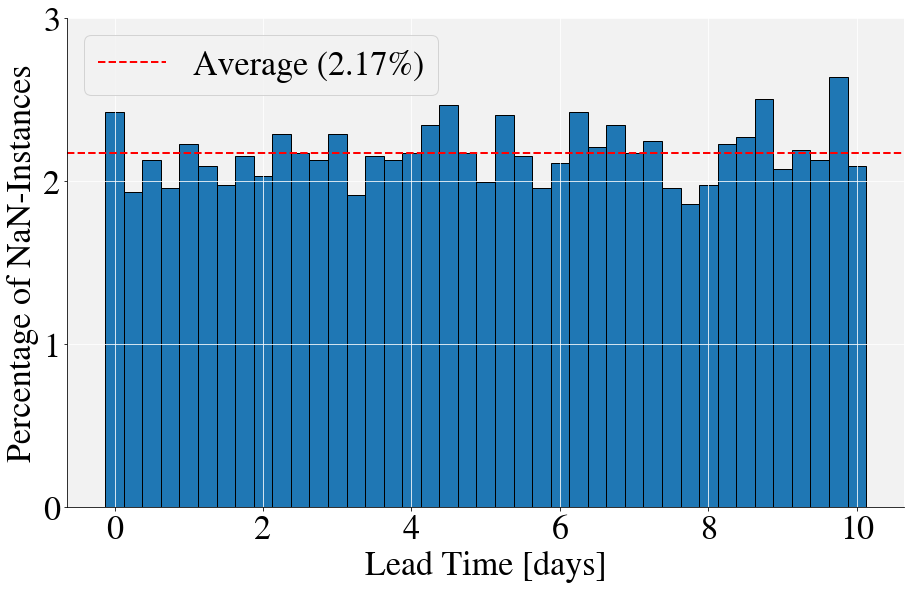

In [213]:
# Convert the counts to a pandas Series for easy plotting
nan_count_series = nan_count_per_pred_timedelta.to_pandas()
days = nan_count_per_pred_timedelta.prediction_timedelta.values / np.timedelta64(1, 'D')
# Calculate the percentage of NaN instances
percentage_nan = (nan_count_series.values / len(all_nan_per_time_pred_timedelta.time)) * 100

# Set up the plot with a refined style
plt.figure(figsize=(15, 9))  # Adjusted figure size for aesthetic spacing
plt.bar(days, percentage_nan, width=0.25, edgecolor='black')

plt.yticks(ticks=np.arange(0, max(percentage_nan) + 1, 1))

avg_percentage = np.mean(percentage_nan)
plt.axhline(y=avg_percentage, color='r', linestyle='--', label=f'Average ({avg_percentage:.2f}%)')

# Add title and labels with a font size that's readable
#plt.title('Histogram of All-NaN Instance Counts across prediction_timedelta', fontsize=15)
plt.xlabel('Lead Time [days]')
plt.ylabel('Percentage of NaN-Instances')

plt.legend(loc='upper left')

plt.savefig('Figures/Data/HRES_Nans_LT.pdf')

# Display the plot
plt.show()

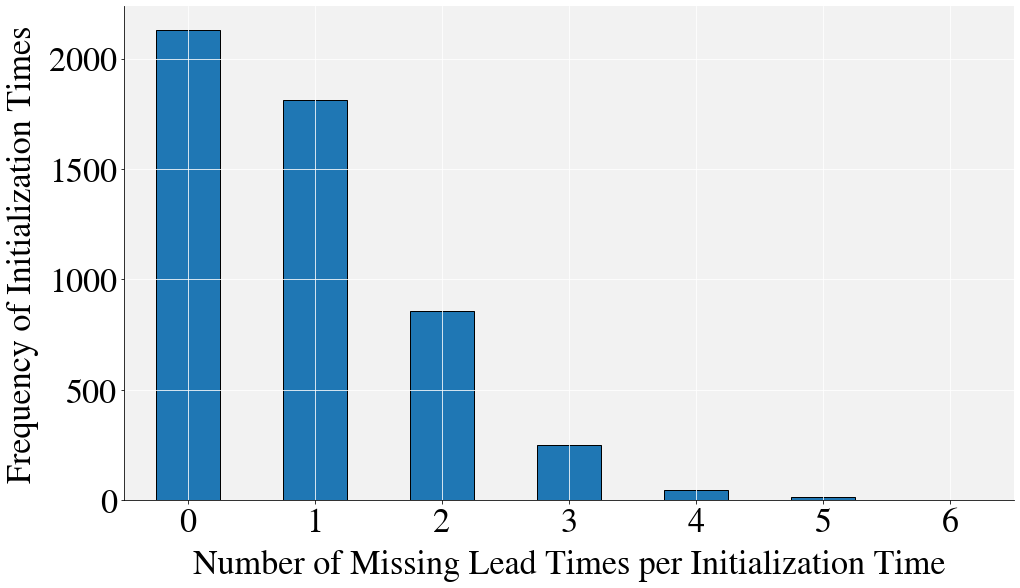

In [214]:
# Set up the plot with a refined style
plt.figure(figsize=(15, 9))  # Adjusted figure size for aesthetic spacing
nan_sum_over_time_series.groupby(nan_sum_over_time_series).size().plot(kind='bar', edgecolor='black')

# Add title and labels with a font size that's readable
#plt.title('Histogram of All-NaN Instance Counts across prediction_timedelta', fontsize=15)
plt.xlabel('Number of Missing Lead Times per Initialization Time', labelpad=10)
plt.ylabel('Frequency of Initialization Times', labelpad=10)
plt.xticks(rotation=0)

plt.tight_layout()

plt.savefig('Figures/Data/HRES_Nans_Time.pdf')

# Display the plot
plt.show()

### Training

In [52]:
%%time
# Load HRES data
forecast = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850)
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
#forecast = forecast.compute()

# Load Analysis data
obs = xr.open_zarr('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

CPU times: user 7.35 s, sys: 984 ms, total: 8.33 s
Wall time: 10.7 s


In [53]:
n_features = 5
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [ ]:
results_df = pd.DataFrame()

for lead_time in tqdm(forecast.prediction_timedelta.values): 

    forecast_subset = forecast.sel(prediction_timedelta=lead_time)
    forecast_subset = forecast_subset.compute()

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)
    
    start_time = time.time()

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    
    # drop NaNs
    obs_train_df = obs_train_df[~forecast_train_df.isna().any(axis=1)]
    obs_val_df = obs_val_df[~forecast_val_df.isna().any(axis=1)]
    obs_test_df = obs_test_df[~forecast_test_df.isna().any(axis=1)]

    forecast_train_df = forecast_train_df[~forecast_train_df.isna().any(axis=1)]
    forecast_val_df = forecast_val_df[~forecast_val_df.isna().any(axis=1)]
    forecast_test_df = forecast_test_df[~forecast_test_df.isna().any(axis=1)]

    for col in forecast_train_df.columns[:-1]:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

    # Fit
    model.fit(
        [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
        obs_train_df.temperature.to_numpy(), 
        validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df.temperature.to_numpy()),
        epochs=100, 
        verbose=1, 
        batch_size=batch_size,
        callbacks=[early_stopping]
        )

    # Predict
    train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    
    # Save the model
    model_save_path = f'DRN/Models/HRES/leadtime_{lead_time}_aux_input_t850.h5'
    model.save(model_save_path)

    # Evaluate
    train_crps = crps_normal_cost_function(obs_train_df.temperature.to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df.temperature.to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df.temperature.to_numpy(), test_predictions, tensor=False)

    # Calculate Spatial metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - test_predictions[:,0]).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - train_predictions[:,0]).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - val_predictions[:,0]).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mse = np_spatial_avg(((obs_test_df.temperature.to_numpy() - test_predictions[:,0])**2).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mse = np_spatial_avg(((obs_train_df.temperature.to_numpy() - train_predictions[:,0])**2).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mse = np_spatial_avg(((obs_val_df.temperature.to_numpy() - val_predictions[:,0])**2).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    train_eval_time = time.time() - start_time

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'train_eval_time': train_eval_time
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    results_df.to_pickle(f'DRN/Final/hres_vs_analysis_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

In [ ]:
%%time
# Load HRES data
forecast = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr')[['2m_temperature','10m_u_component_of_wind','10m_v_component_of_wind','mean_sea_level_pressure']]
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
forecast = forecast.compute()

# Load Analysis data
obs = xr.open_zarr('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_conservative.zarr')['2m_temperature'].sel(time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

In [ ]:
n_features = 4  
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [ ]:
results_df = pd.DataFrame() #pd.read_pickle(f'DRN/Final/T2M/hres_vs_era5_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

for lead_time in tqdm(forecast.prediction_timedelta.values): 

    start_time = time.time()

    forecast_subset = forecast.sel(prediction_timedelta=lead_time)

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns= ['prediction_timedelta','latitude','longitude'])
    obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])

    for col in forecast_train_df.columns[:-1]:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

    # Fit
    model.fit(
        [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
        obs_train_df['2m_temperature'].to_numpy(), 
        validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df['2m_temperature'].to_numpy()),
        epochs=100, 
        verbose=0, 
        batch_size=batch_size,
        callbacks=[early_stopping]
        )

    # Predict
    train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)

    # Save the model
    model_save_path = f'DRN/Models/T2M/HRES/leadtime_{lead_time}_aux_input_t2m.h5'
    model.save(model_save_path)

    # Evaluate
    train_crps = crps_normal_cost_function(obs_train_df['2m_temperature'].to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df['2m_temperature'].to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df['2m_temperature'].to_numpy(), test_predictions, tensor=False)

    # Calculate Spatial metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df['2m_temperature'].to_numpy() - test_predictions[:,0]).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df['2m_temperature'].to_numpy() - train_predictions[:,0]).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df['2m_temperature'].to_numpy() - val_predictions[:,0]).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mse = np_spatial_avg(((obs_test_df['2m_temperature'].to_numpy() - test_predictions[:,0])**2).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mse = np_spatial_avg(((obs_train_df['2m_temperature'].to_numpy() - train_predictions[:,0])**2).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mse = np_spatial_avg(((obs_val_df['2m_temperature'].to_numpy() - val_predictions[:,0])**2).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(forecast_test['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(forecast_train['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(forecast_val['2m_temperature'].unstack('combined').shape).mean(axis=0),forecast_val.unstack('combined'))

    train_eval_time = time.time() - start_time

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'train_eval_time': train_eval_time
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    results_df.to_pickle(f'DRN/Final/T2M/hres_vs_era5_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

## ENS

In [26]:
%%time
# Load HRES data
ens = xr.open_zarr('gs://weatherbench2/datasets/ens/2018-2022-64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850)

mean_ens = ens.mean(dim='number')
std_ens = ens.std(dim='number')

forecast = xr.Dataset({
    'temperature_mean': mean_ens['temperature'],
    'temperature_std': std_ens['temperature'],
    'geopotential_mean': mean_ens['geopotential'],
    'geopotential_std': std_ens['geopotential'],
    'specific_humidity_mean': mean_ens['specific_humidity'],
    'specific_humidity_std': std_ens['specific_humidity'],
    'u_component_of_wind_mean': mean_ens['u_component_of_wind'],
    'u_component_of_wind_std': std_ens['u_component_of_wind'],
    'v_component_of_wind_mean': mean_ens['v_component_of_wind'],
    'v_component_of_wind_std': std_ens['v_component_of_wind']
}, coords=mean_ens.coords)

# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
#forecast = forecast.compute()

# Load Analysis data
obs = xr.open_zarr('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

CPU times: user 9.59 s, sys: 1.15 s, total: 10.7 s
Wall time: 12.3 s


In [27]:
n_features = 10
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [ ]:
results_df = pd.DataFrame()

for lead_time in tqdm(forecast.prediction_timedelta.values): 

    forecast_subset = forecast.sel(prediction_timedelta=lead_time)
    forecast_subset = forecast_subset.compute()

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)
    
    start_time = time.time()

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['level','prediction_timedelta','latitude','longitude'])
    
    # drop NaNs
    obs_train_df = obs_train_df[~forecast_train_df.isna().any(axis=1)]
    obs_val_df = obs_val_df[~forecast_val_df.isna().any(axis=1)]
    obs_test_df = obs_test_df[~forecast_test_df.isna().any(axis=1)]

    forecast_train_df = forecast_train_df[~forecast_train_df.isna().any(axis=1)]
    forecast_val_df = forecast_val_df[~forecast_val_df.isna().any(axis=1)]
    forecast_test_df = forecast_test_df[~forecast_test_df.isna().any(axis=1)]

    for col in forecast_train_df.columns[:-1]:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

    # Fit
    model.fit(
        [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
        obs_train_df.temperature.to_numpy(), 
        validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df.temperature.to_numpy()),
        epochs=100, 
        verbose=1, 
        batch_size=batch_size,
        callbacks=[early_stopping]
        )

    # Predict
    train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    
    # Save the model
    model_save_path = f'DRN/Models/ENS/leadtime_{lead_time}_aux_input_t850.h5'
    model.save(model_save_path)

    # Evaluate
    train_crps = crps_normal_cost_function(obs_train_df.temperature.to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df.temperature.to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df.temperature.to_numpy(), test_predictions, tensor=False)

    # Calculate Spatial metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df.temperature.to_numpy() - test_predictions[:,0]).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df.temperature.to_numpy() - train_predictions[:,0]).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df.temperature.to_numpy() - val_predictions[:,0]).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mse = np_spatial_avg(((obs_test_df.temperature.to_numpy() - test_predictions[:,0])**2).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mse = np_spatial_avg(((obs_train_df.temperature.to_numpy() - train_predictions[:,0])**2).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mse = np_spatial_avg(((obs_val_df.temperature.to_numpy() - val_predictions[:,0])**2).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    train_eval_time = time.time() - start_time

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'train_eval_time': train_eval_time
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    results_df.to_pickle(f'DRN/Final/ens_vs_analysis_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

In [39]:
%%time
# Load HRES data
ens = xr.open_zarr('gs://weatherbench2/datasets/ens/2018-2022-64x32_equiangular_conservative.zarr')[['2m_temperature','10m_u_component_of_wind','10m_v_component_of_wind','mean_sea_level_pressure']]

mean_ens = ens.mean(dim='number')
std_ens = ens.std(dim='number')

forecast = xr.Dataset({
    '2m_temperature_mean': mean_ens['2m_temperature'],
    '2m_temperature_std': std_ens['2m_temperature'],
    'mean_sea_level_pressure_mean': mean_ens['mean_sea_level_pressure'],
    'mean_sea_level_pressure_std': std_ens['mean_sea_level_pressure'],
    '10m_u_component_of_wind_mean': mean_ens['10m_u_component_of_wind'],
    '10m_u_component_of_wind_std': std_ens['10m_u_component_of_wind'],
    '10m_v_component_of_wind_mean': mean_ens['10m_v_component_of_wind'],
    '10m_v_component_of_wind_std': std_ens['10m_v_component_of_wind']
}, coords=mean_ens.coords)

# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)
#forecast = forecast.compute()

# Load Analysis data
obs = xr.open_zarr('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_conservative.zarr')['2m_temperature'].sel(time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.stack(combined=('latitude', 'longitude'))
obs['location_id'] = ('combined', mapped_ids)
obs = obs.compute()

CPU times: user 5.23 s, sys: 205 ms, total: 5.43 s
Wall time: 7.77 s


In [40]:
n_features = 8
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [ ]:
results_df = pd.DataFrame()

for lead_time in tqdm(forecast.prediction_timedelta.values): 

    forecast_subset = forecast.sel(prediction_timedelta=lead_time)
    forecast_subset = forecast_subset.compute()

    # Split forecast data into training and test sets
    forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2018-12-31')),
                             forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
    forecast_val = forecast_subset.sel(time=slice('2019-01-01', '2019-12-31'))
    forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

    # Load ERA5 data
    obs_train = obs.sel(time=forecast_train.time + lead_time)
    obs_val = obs.sel(time=forecast_val.time + lead_time)
    obs_test = obs.sel(time=forecast_test.time + lead_time)
    
    start_time = time.time()

    # Extract dataframes
    forecast_train_df = forecast_train.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    forecast_val_df = forecast_val.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    forecast_test_df = forecast_test.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    obs_train_df = obs_train.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])
    obs_val_df = obs_val.to_dataframe().reset_index(drop=True).drop(columns= ['prediction_timedelta','latitude','longitude'])
    obs_test_df = obs_test.to_dataframe().reset_index(drop=True).drop(columns=['prediction_timedelta','latitude','longitude'])

    # drop NaNs
    obs_train_df = obs_train_df[~forecast_train_df.isna().any(axis=1)]
    obs_val_df = obs_val_df[~forecast_val_df.isna().any(axis=1)]
    obs_test_df = obs_test_df[~forecast_test_df.isna().any(axis=1)]

    forecast_train_df = forecast_train_df[~forecast_train_df.isna().any(axis=1)]
    forecast_val_df = forecast_val_df[~forecast_val_df.isna().any(axis=1)]
    forecast_test_df = forecast_test_df[~forecast_test_df.isna().any(axis=1)]

    for col in forecast_train_df.columns[:-1]:
        # Apply the scaler to the training data
        forecast_train_df[col], train_min, train_max = min_max_scale(forecast_train_df[col])
        # Apply the same scaler to the validation and test data
        forecast_val_df[col] = (forecast_val_df[col] - train_min) / (train_max - train_min)
        forecast_test_df[col] = (forecast_test_df[col]- train_min) / (train_max - train_min)

    # Resetting the TensorFlow graph might be unnecessary in most cases, but it's here to ensure a clean slate
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()

    # Model definition
    model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

    # Fit
    model.fit(
        [forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], 
        obs_train_df['2m_temperature'].to_numpy(), 
        validation_data=([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], obs_val_df['2m_temperature'].to_numpy()),
        epochs=100, 
        verbose=1, 
        batch_size=batch_size,
        callbacks=[early_stopping]
        )

    # Predict
    train_predictions = model.predict([forecast_train_df.iloc[:, :-1].to_numpy(), forecast_train_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    val_predictions = model.predict([forecast_val_df.iloc[:, :-1].to_numpy(), forecast_val_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)
    test_predictions = model.predict([forecast_test_df.iloc[:, :-1].to_numpy(), forecast_test_df.location_id.to_numpy()], verbose=0, batch_size=batch_size)

    # Evaluate
    train_crps = crps_normal_cost_function(obs_train_df['2m_temperature'].to_numpy(), train_predictions, tensor=False)
    val_crps = crps_normal_cost_function(obs_val_df['2m_temperature'].to_numpy(), val_predictions, tensor=False)
    test_crps = crps_normal_cost_function(obs_test_df['2m_temperature'].to_numpy(), test_predictions, tensor=False)

    # Calculate Spatial metrics
    spatial_mean_test_crps = np_spatial_avg(test_crps.numpy().reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_mean_train_crps = np_spatial_avg(train_crps.numpy().reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_mean_val_crps = np_spatial_avg(val_crps.numpy().reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mae = np_spatial_avg(np.abs(obs_test_df['2m_temperature'].to_numpy() - test_predictions[:,0]).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mae = np_spatial_avg(np.abs(obs_train_df['2m_temperature'].to_numpy() - train_predictions[:,0]).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mae = np_spatial_avg(np.abs(obs_val_df['2m_temperature'].to_numpy() - val_predictions[:,0]).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_mse = np_spatial_avg(((obs_test_df['2m_temperature'].to_numpy() - test_predictions[:,0])**2).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_mse = np_spatial_avg(((obs_train_df['2m_temperature'].to_numpy() - train_predictions[:,0])**2).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_mse = np_spatial_avg(((obs_val_df['2m_temperature'].to_numpy() - val_predictions[:,0])**2).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    spatial_test_var = np_spatial_avg(((test_predictions[:,1])**2).reshape(int(len(forecast_test_df) / 2048), 32, 64).mean(axis=0),forecast_test.unstack('combined'))
    spatial_train_var = np_spatial_avg(((train_predictions[:,1])**2).reshape(int(len(forecast_train_df) / 2048), 32, 64).mean(axis=0),forecast_train.unstack('combined'))
    spatial_val_var = np_spatial_avg(((val_predictions[:,1])**2).reshape(int(len(forecast_val_df) / 2048), 32, 64).mean(axis=0),forecast_val.unstack('combined'))

    train_eval_time = time.time() - start_time

    temp_results = {
        'lead_time': lead_time,
        'crps_test': spatial_mean_test_crps,
        'crps_train': spatial_mean_train_crps,
        'crps_val': spatial_mean_val_crps,
        'mae_test': spatial_test_mae,
        'mae_train': spatial_train_mae,
        'mae_tval': spatial_val_mae,
        'mse_test': spatial_test_mse,
        'mse_train': spatial_train_mse,
        'mse_val': spatial_val_mse,
        'var_test': spatial_test_var,
        'var_train': spatial_train_var,
        'var_val': spatial_val_var,
        'train_eval_time': train_eval_time
    }
    temp_df = pd.DataFrame([temp_results])
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    results_df.to_pickle(f'DRN/Final/T2M/ens_vs_analysis_aux_input_hidden{hidden_units}_emb{emb_size}_l2_001.pkl')

# Parameters

In [ ]:
%%time
# Load PANGU data
forecast = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')[['temperature', 'geopotential', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].sel(level=850)
# Stack the DataArray along latitude and longitude
forecast = forecast.stack(combined=('latitude', 'longitude'))
# Generate a mapping from lat_lon_ids to integers
lat_lon_ids = ["{}_{}".format(lat, lon) for lat, lon in zip(forecast.latitude.values, forecast.longitude.values)]
id_to_int = {id_str: i for i, id_str in enumerate(lat_lon_ids)}
mapped_ids = np.vectorize(id_to_int.get)(lat_lon_ids)
forecast['location_id'] = ('combined', mapped_ids)

CPU times: user 2.42 s, sys: 123 ms, total: 2.55 s
Wall time: 12.3 s


In [27]:
n_features = 5  
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [28]:
model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 2)         4096        ['input_6[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 2)            0           ['embedding_2[0][0]']            
                                                                                            

In [30]:
n_features = 4 
n_outputs = 2  
hidden_units = [64]
emb_size = 2
max_id = forecast['location_id'].max().values
batch_size = 8192

In [31]:
model = build_model_pos_out(n_features, n_outputs, hidden_units, emb_size, max_id, lr=0.001, reg=l2(0.01))

In [32]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 2)         4096        ['input_8[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 2)            0           ['embedding_3[0][0]']            
                                                                                            